# Trust Region Optimization in CVX

------
A notebook by Albert Tan

------

## Single Constraint Quadratic Optimization

We explore the QCQP problem with one quadratic constraint:

minimize $
\;\;\; x^{T}A_{0}x + 2b_{0}^{T}x+c_{0}  
$


s.t. $
\;\;\; \; \; \; \; \; x^{T}A_{1}x + 2b_{1}^{T}x+c_{1}\leq 0
$
$\;\;\;\;\;\;\;\;\;\;\;\;\; \;$ <span style='color:Red'> (P.1)  </span>

with $x\in R^{n}$, $A_i\in S^{n}$, $b_{i}\in R^{n}$, $c_i\in R$

Problem <span style='color:Red'> (P.1)  </span> is a non-convex optimization problem, because we do not assume $A_i\succeq 0$. However, we demonstrate that the optimal solution can still be obtained by solving its SDR (semi-definite relaxation). 


If Slater's condition holds and there exists a feasible $x$ such that $x^{T}A_{1}x + 2b_{1}^{T}x+c_{1}<0$, then strong duality holds with the original problem <span style='color:Red'> (P.1)  </span> and its dual SDP:


maximize $
\; \gamma
$


s.t. $
\; \; \; \; \; \; \; \; \lambda\geq0
$

$
\begin{align}
\; \; \; \; \; \; \; \; \; \; \begin{bmatrix} A_{0} + \lambda A_{1} & b_{0}+\lambda b_{1} \\ (b_{0}+\lambda b_{1})^{T} & c_0+\lambda c_{1}-\gamma  \end{bmatrix}\succeq 0
\end{align}
$
$\;$<span style='color:Red'> (P.2)  </span>

with SDP variables  $\gamma\ , \lambda\in R$ 

Strong duality also holds between <span style='color:Red'> (P.2)  </span> and its dual SDP relaxation:


minimize $
\; \;\; tr(A_{0}x) + 2b_{0}^{T}x+c_{0}  
$


s.t. $
\; \;\;\; \; \; \; \; \; \;  tr(A_{1}x) + 2b_{1}^{T}x+c_{1}\leq 0
$

$
\begin{align}
\; \; \; \;\;\; \; \; \; \; \; \; \begin{bmatrix} X & x \\ x^{T} & 1  \end{bmatrix}\succeq 0 \end{align}
$
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$<span style='color:Red'> (P.3)  </span>

with SDP variables  $X\in S^{n}$, $x\in R^{n}$

Thus, solving the SDR <span style='color:Red'> (P.3)  </span> will provide the exact solution of the original non-convex <span style='color:Red'> (P.1)  </span> provided that original problem is feasible.

## Trust Region Optimization

The above techniques provide a way to solve the non-convex problem of minimizing a quadratic function over a unit ball. This is known as the "trust region problem" (Boyd page 229) which has many applications in nonlinear optimization as it breaks down an initially NP-Hard optimization problem to a sequence of easier trust region subproblems:

minimize $
\;\;\; x^{T}Ax + 2b^{T}x  
$


s.t. $
\;\;\; \; \; \; \; \; \; \; x^{T}x \leq 1
$

where $A\in S^{n}, x\in R^{n}, b\in R^{n}$  but $A\nsucc0$

Each trust region subproblems can be solved with the SDR:

minimize $
\; \;\;tr(AX) + 2b^{T}x  
$


s.t. $
\; \;\;\; \; \; \; \; \; \; tr(I_{n}X) -1 \leq 0
$

$
\begin{align}
\; \; \; \;\;\; \; \; \; \; \; \; \begin{bmatrix} X & x \\ x^{T} & 1  \end{bmatrix}\succeq 0 \end{align}
$

with SDR variables $X\in S^{n}, x\in R^{n}$


## Trust Region CVX Example

For easiest visualization of the objective function as a 3-D surface, let $x\in R^{2}$. We demonstrate a simple example of the trust-region problem by letting 
$
\begin{align}
A=\begin{bmatrix} 1 & 0 \\ 0 & -1  \end{bmatrix}\preceq 0 \end{align}
$,
$
\begin{align}
b=\begin{bmatrix} -1 \\ 0   \end{bmatrix}. \end{align}
$
Since $A$ is not PSD (A has negative eigenvalues), the following problem below is not convex:

minimize $
\;\;\; x^{T}Ax + 2b^{T}x  =x_{1}^{2}-x_2^{2}-2x_{1}
$


s.t. $
\;\;\; \; \; \; \; \; \; \; x^{T}x = x_1^{2}+x_2^{2}\leq 1
$

Using the SDR specified in the above section, we can solve this problem in CVX:

In [230]:
import numpy as np
import cvxpy as cp
import scipy.linalg as la
import math

In [255]:
n=2 #R2
A= np.array([[1, 0], [0, -1]])
zero = 1e-4 #floating point 0
b0=np.array([[-1],[zero]])

# Define and solve the SDP problem.
# Create a symmetric matrix variable.
X = cp.Variable((n,n), symmetric=True)
x = cp.Variable((n,1))

# set constraints
constraint=[cp.trace(np.identity(n)@X)<=1] #trace inequality condition

C1=cp.hstack((X, x))
C2=cp.hstack((x.T, np.array([[1]])))
C3=cp.vstack((C1,C2))
constraint += [C3>>0] # Matrix inequality condition

#cvx problem
prob = cp.Problem(cp.Minimize(cp.trace(A@X) + 2*b0.T@x),
                  constraint)
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)
print("A solution x is")
print(x.value)

The optimal value is -1.5001732066441813
A solution X is
[[ 0.24997114 -0.4329933 ]
 [-0.4329933   0.75002886]]
A solution x is
[[ 0.49997114]
 [-0.86603658]]


### A visualization of d* at x* is provided below

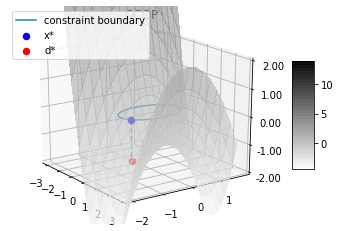

In [256]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

point1 = [x.value[0], x.value[1], 0]
point2 = [x.value[0], x.value[1], prob.value]

# Make data.
X = np.arange(-3, 3, 0.25)
Y = np.arange(-2, 2, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X**2 - Y**2 -2*X

# Plot a sin curve using the x and y axes.
theta=np.linspace(0, 2, 100)
x = np.cos(theta*np.pi) 
y = np.sin(theta* np.pi) 
ax.plot(x, y, zs=0, label='constraint boundary')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.binary,
                       linewidth=0, antialiased=False,alpha=0.65)

# Customize the z axis.
ax.set_zlim(-2, 2)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=20., azim=-35)
ax.scatter(point1[0], point1[1], zs=point1[2], c='b',linewidths=3, label='x*')
ax.scatter(point2[0], point2[1], zs=point2[2], c='r',linewidths=3,label='d*')

x_values = [point1[0], point2[0]]

y_values = [point1[1], point2[1]]

z_values = [point1[2], point2[2]]


plt.plot(x_values, y_values, z_values, ls='dashed')

ax.set_title('QCQP')
ax.legend(loc='upper left')
plt.show()

## Trust Region Implementation on Random Synthetic Data:

In [234]:
n=3 #R3

A = np.random.randn(n, n)
A = A.T @ A
print('A = \n', A)
b0=np.random.randn(n, 1)
print('b= \n', b0)

# Define and solve the CVXPY problem.
# Create a symmetric matrix variable.
X = cp.Variable((n,n), symmetric=True)
x = cp.Variable((n,1))

# set constraints
constraint=[cp.trace(np.identity(n)@X)<=1] #trace inequality condition

C1=cp.hstack((X, x))
C2=cp.hstack((x.T, np.array([[1]])))
C3=cp.vstack((C1,C2))
constraint += [C3>>0] # Matrix inequality condition

#cvx problem
prob = cp.Problem(cp.Minimize(cp.trace(A@X) + 2*b0.T@x),
                  constraint)
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)
print("A solution x is")
print(x.value)

A = 
 [[ 0.97706458  0.66578243  0.49503177]
 [ 0.66578243  3.50766883 -0.36819528]
 [ 0.49503177 -0.36819528  1.45332496]]
b= 
 [[ 2.14464413]
 [-2.05594629]
 [ 0.14929074]]
The optimal value is -4.800871773602411
A solution X is
[[ 0.74261891 -0.42171876 -0.11527948]
 [-0.42171876  0.23948583  0.06546496]
 [-0.11527948  0.06546496  0.01789525]]
A solution x is
[[-0.8617534 ]
 [ 0.4893729 ]
 [ 0.13377316]]
